<a href="https://colab.research.google.com/github/jlopetegui98/Creation-of-a-synthetic-dataset-for-French-NER-in-clinical-trial-texts/blob/main/Multilingual-NER-Model/multilingual_ner_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Multilingual NER model**

The idea of this approach is based on the work presented in this [blog](https://pradeepundefned.medium.com/how-to-do-named-entity-recognition-for-languages-other-than-english-bac58898ad33).

To validate the use of this approach to generate a synthetic dataset in french we are going to evaluate the performance of the implemented model over a dataset already annotated in English and French. The chosen dataset is [multiNERD](https://huggingface.co/datasets/Babelscape/multinerd). Among the languages in the corpus we will focus just in these two mentioned before.

In [1]:
# uncomment to install required dependencies in colab
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets
!pip install seqeval
!pip install -q -U wandb

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 750.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=4060f005c509713344dd76b54d5ae7eb41dee3240b68176089889e3abfdf4bad
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.5 MB/s eta 0:00

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
from datasets import load_dataset, load_metric
import torch
import accelerate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb

In [4]:
model_name = "xlm-roberta-base"

In [5]:
dataset = load_dataset("Babelscape/multinerd")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [6]:
# check the format of the dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'lang'],
        num_rows: 2678400
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'lang'],
        num_rows: 334800
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'lang'],
        num_rows: 335986
    })
})

In [7]:
# get split of the dataset
data_train = dataset['train']
data_test = dataset['test']
data_val = dataset['validation']

In [8]:
labels_vocab = {
    "O": 0,
    "B-PER": 1,
    "I-PER": 2,
    "B-ORG": 3,
    "I-ORG": 4,
    "B-LOC": 5,
    "I-LOC": 6,
    "B-ANIM": 7,
    "I-ANIM": 8,
    "B-BIO": 9,
    "I-BIO": 10,
    "B-CEL": 11,
    "I-CEL": 12,
    "B-DIS": 13,
    "I-DIS": 14,
    "B-EVE": 15,
    "I-EVE": 16,
    "B-FOOD": 17,
    "I-FOOD": 18,
    "B-INST": 19,
    "I-INST": 20,
    "B-MEDIA": 21,
    "I-MEDIA": 22,
    "B-MYTH": 23,
    "I-MYTH": 24,
    "B-PLANT": 25,
    "I-PLANT": 26,
    "B-TIME": 27,
    "I-TIME": 28,
    "B-VEHI": 29,
    "I-VEHI": 30,
}

label_list = list(labels_vocab.keys())
labels_vocab_reverse = {v:k for k,v in labels_vocab.items()}

In [ ]:
data_train[0]

{'tokens': ['2002',
  'ging',
  'er',
  'ins',
  'Ausland',
  'und',
  'wechselte',
  'für',
  '750.000',
  'Pfund',
  'Sterling',
  'zu',
  'Manchester',
  'City',
  '.'],
 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0],
 'lang': 'de'}

In [ ]:
# first 5 examples
for i in range(5):
    print(data_train[i]['tokens'], [labels_vocab_reverse[x] for x in data_train[i]['ner_tags']])

['2002', 'ging', 'er', 'ins', 'Ausland', 'und', 'wechselte', 'für', '750.000', 'Pfund', 'Sterling', 'zu', 'Manchester', 'City', '.'] ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O']
['Die', 'Provinzhauptstadt', 'Burgos', 'ist', 'knapp', '80', 'km', '(', 'Fahrtstrecke', ')', 'in', 'nordwestlicher', 'Richtung', 'entfernt', ';', 'die', 'Stadt', 'Aranda', 'de', 'Duero', 'befindet', 'sich', 'ca.', '26', 'km', 'südwestlich', '.'] ['O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'I-LOC', 'I-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['in', 'Großbritannien', 'und', 'den', 'USA', '.'] ['O', 'B-LOC', 'O', 'O', 'B-LOC', 'O']
['Die', 'Blätter', 'des', 'Huflattichs', 'sind', 'leicht', 'mit', 'den', 'sehr', 'ähnlichen', 'Blättern', 'der', 'Weißen', 'Pestwurz', '(', '"', 'Petasites', 'albus', '"', ')', 'zu', 'verwechseln', '.'] ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PLANT', 'I-PLANT', 'O', 'O',

In [ ]:
# check the length of the dataset
len(data_train), len(data_test), len(data_val)

(2678400, 335986, 334800)

In [ ]:
# check languages in the dataset
languages = set()
for i in range(len(data_train)):
    languages.add(data_train[i]['lang'])
languages

{'de', 'en', 'es', 'fr', 'it', 'nl', 'pl', 'pt', 'ru', 'zh'}

As we can see there are 10 languages availables in the dataset. Now we are going to check the language distribution over test, train and validation sets

In [ ]:
lang_df = pd.DataFrame(columns = ['lang', 'train', 'test', 'val'])
lang_df['lang'] = list(languages)
lang_df.set_index('lang', inplace=True)
lang_df = lang_df.fillna(0)
lang_df

,train,test,val
lang,,,
fr,0,0,0
ru,0,0,0
pl,0,0,0
zh,0,0,0
nl,0,0,0
en,0,0,0
pt,0,0,0
it,0,0,0
es,0,0,0


In [ ]:
for i in tqdm(range(len(data_train))):
    lang_df.loc[data_train[i]['lang'], 'train'] += 1
for i in tqdm(range(len(data_test))):
    lang_df.loc[data_test[i]['lang'], 'test'] += 1
for i in tqdm(range(len(data_val))):
    lang_df.loc[data_val[i]['lang'], 'val'] += 1
lang_df

100%|██████████| 334800/334800 [01:45<00:00, 3172.83it/s]


,train,test,val
lang,,,
fr,281760,35390,35220
ru,132480,16676,16560
pl,311840,39110,38980
zh,312320,39154,39040
nl,274720,34362,34340
en,262560,32908,32820
pt,284000,35630,35500
it,291040,36434,36380
es,276960,34798,34620


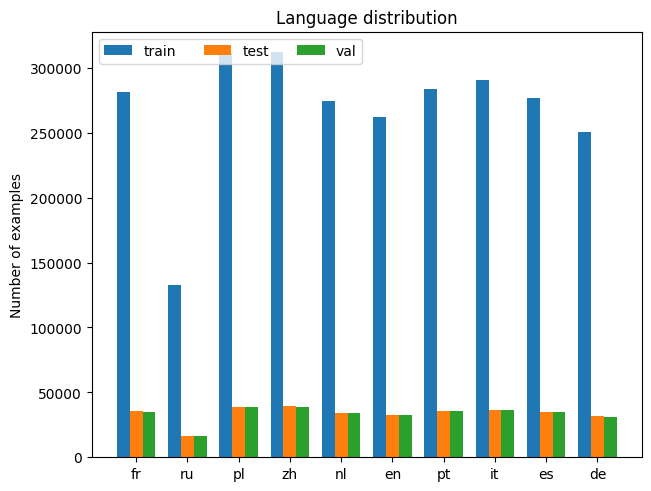

In [ ]:
x = np.arange(len(languages))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for subset in ['train', 'test', 'val']:
    offset = width * multiplier
    rects = ax.bar(x + offset, lang_df[subset], width, label=subset)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of examples')
ax.set_title('Language distribution')
ax.set_xticks(x + width, lang_df.index)
ax.legend(loc='upper left', ncols=3)

plt.show()

In [9]:
# now let us focus on English and French

# English
data_train_en = data_train.filter(lambda example: example['lang'] == 'en')
data_test_en = data_test.filter(lambda example: example['lang'] == 'en')
data_val_en = data_val.filter(lambda example: example['lang'] == 'en')
print(f"Distribution of English data:\nTrain: {len(data_train_en)}\nTest: {len(data_test_en)}\nVal: {len(data_val_en)}")

# French
data_train_fr = data_train.filter(lambda example: example['lang'] == 'fr')
data_test_fr = data_test.filter(lambda example: example['lang'] == 'fr')
data_val_fr = data_val.filter(lambda example: example['lang'] == 'fr')
print(f"Distribution of French data:\nTrain: {len(data_train_fr)}\nTest: {len(data_test_fr)}\nVal: {len(data_val_fr)}")

Filter:   0%|          | 0/2678400 [00:00<?, ? examples/s]

Filter:   0%|          | 0/335986 [00:00<?, ? examples/s]

Filter:   0%|          | 0/334800 [00:00<?, ? examples/s]

Distribution of English data:
Train: 262560
Test: 32908
Val: 32820


Filter:   0%|          | 0/2678400 [00:00<?, ? examples/s]

Filter:   0%|          | 0/335986 [00:00<?, ? examples/s]

Filter:   0%|          | 0/334800 [00:00<?, ? examples/s]

Distribution of French data:
Train: 281760
Test: 35390
Val: 35220


**Model Implementation**

In [10]:
# get xlm-roberta tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# check the tokenizer
tokens_ = tokenizer("The AI master at Université Paris-Saclay is very good").tokens()
print(tokens_)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

['<s>', '▁The', '▁AI', '▁master', '▁at', '▁', 'Université', '▁Paris', '-', 'S', 'ac', 'lay', '▁is', '▁very', '▁good', '</s>']


In [11]:
tokens_ = tokenizer("The AI master at Université Paris-Saclay is very good")
tokens_.word_ids()

[None, 0, 1, 2, 3, 4, 4, 5, 5, 5, 5, 5, 6, 7, 8, None]

We can notice that this tokenizer is a subword based tokenizer and that it also keeps the information about spaces. At the begining and the end of the sentences we have the special tokens $<s>$ and $</s>$ which in word_ids are assigned to None and have token_id 0.

Now we are going to apply the tokenization over the entire English and French dataset to and align the labels with the corresponding tokens. If a subword belongs to a word originally labeled as 'B-ENT' then if it is the first subword it will keep this label, otherwise it will be 'I-ENT'.

In [12]:
# tokenize and align the labels in the dataset
def tokenize_and_align_labels(sentence, flag = 'I'):
    """
    Tokenize the sentence and align the labels
    inputs:
        sentence: dict, the sentence from the dataset
        flag: str, the flag to indicate how to deal with the labels for subwords
            - 'I': use the label of the first subword for all subwords but as intermediate (I-ENT)
            - 'B': use the label of the first subword for all subwords as beginning (B-ENT)
            - None: use -100 for subwords
    outputs:
        tokenized_sentence: dict, the tokenized sentence now with a field for the labels
    """
    tokenized_sentence = tokenizer(sentence['tokens'], is_split_into_words=True, truncation=True)

    labels = []
    for i, labels_s in enumerate(sentence['ner_tags']):
        word_ids = tokenized_sentence.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # if the word_idx is None, assign -100
            if word_idx is None:
                label_ids.append(-100)
            # if it is a new word, assign the corresponding label
            elif word_idx != previous_word_idx:
                label_ids.append(labels_s[word_idx])
            # if it is the same word, check the flag to assign
            else:
                if flag == 'I':
                    if label_list[labels_s[word_idx]].startswith('I'):
                      label_ids.append(labels_s[word_idx])
                    else:
                      label_ids.append(labels_s[word_idx] + 1)
                elif flag == 'B':
                    label_ids.append(labels_s[word_idx])
                elif flag == None:
                    label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_sentence['labels'] = labels
    return tokenized_sentence

In [13]:
# apply the function to the dataset
tokenized_train_en = data_train_en.map(tokenize_and_align_labels, batched=True)
tokenized_test_en = data_test_en.map(tokenize_and_align_labels, batched=True)
tokenized_val_en = data_val_en.map(tokenize_and_align_labels, batched=True)

tokenized_train_fr = data_train_fr.map(tokenize_and_align_labels, batched=True)
tokenized_test_fr = data_test_fr.map(tokenize_and_align_labels, batched=True)
tokenized_val_fr = data_val_fr.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/262560 [00:00<?, ? examples/s]

Map:   0%|          | 0/32908 [00:00<?, ? examples/s]

Map:   0%|          | 0/32820 [00:00<?, ? examples/s]

Map:   0%|          | 0/281760 [00:00<?, ? examples/s]

Map:   0%|          | 0/35390 [00:00<?, ? examples/s]

Map:   0%|          | 0/35220 [00:00<?, ? examples/s]

In [14]:
# import the model
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(label_list), label2id=labels_vocab, id2label=labels_vocab_reverse)
print(model)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaForTokenClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bi

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
device

device(type='cuda')

In [17]:
model.to(device)

XLMRobertaForTokenClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bi

In [18]:
args = TrainingArguments(
    report_to = 'wandb',
    run_name = "multinerd-multilingual-ner",
    output_dir = "multinerd-multilingual-ner",
    evaluation_strategy = "steps",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    push_to_hub=False,
    eval_steps=100,
    save_steps=10000,
    logging_steps=100,
)

In [19]:
data_collator = DataCollatorForTokenClassification(tokenizer)

In [20]:
metric = load_metric("seqeval")

<ipython-input-20-e20ba34f8cc7>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:753: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [21]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [22]:
args = TrainingArguments(
    report_to = 'wandb',
    run_name = "multinerd-multilingual-ner",
    output_dir = "multinerd-multilingual-ner",
    evaluation_strategy = "steps",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    push_to_hub=False,
    eval_steps=100,
    save_steps=10000,
    logging_steps=100,
)

In [23]:
# let us try with 20 % of the english data
data_train =  tokenized_train_en.train_test_split(test_size=0.8)['train']

In [24]:
trainer = Trainer(
    model,
    args,
    train_dataset=data_train,
    eval_dataset=tokenized_test_fr,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [25]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [26]:
wandb.init(project = "Multilingual-NER-multinerd_french_tr")

wandb: Currently logged in as: jlopetegui98 (javier-lopetegui-gonzalez). Use `wandb login --relogin` to force relogin


In [27]:
outputs_train = trainer.train()

Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,0.898400,0.346071,0.913008,0.909921,0.911462,0.937924
200,0.242600,0.286429,0.913813,0.927556,0.920633,0.946993
300,0.159800,0.279979,0.926909,0.939513,0.933169,0.953543
400,0.153100,0.256505,0.930579,0.943941,0.937213,0.956487
500,0.142500,0.244598,0.933068,0.937932,0.935494,0.955429
600,0.140600,0.252368,0.934657,0.940614,0.937626,0.956541
700,0.110200,0.251613,0.940038,0.934700,0.937362,0.956202
800,0.108600,0.221097,0.937213,0.936412,0.936812,0.956946
900,0.116000,0.211793,0.936200,0.947488,0.941810,0.960270
1000,0.106200,0.214075,0.938045,0.937017,0.937531,0.957211


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
outputs_eval = trainer.evaluate()

In [ ]:
torch.save(model, './drive/MyDrive/HandsOn-NLP/multiNER_model_en.pt')

In [ ]:
eval_french = trainer.evaluate(tokenized_test_fr)
eval_french

{'eval_loss': 0.24954213201999664,
 'eval_precision': 0.9500922643009666,
 'eval_recall': 0.9505200646391067,
 'eval_f1': 0.9503061163242031,
 'eval_accuracy': 0.964894731899149,
 'eval_runtime': 239.3144,
 'eval_samples_per_second': 147.881,
 'eval_steps_per_second': 18.486,
 'epoch': 3.0}

In [ ]:
print(outputs_train)

TrainOutput(global_step=49230, training_loss=0.04051068181699063, metrics={'train_runtime': 14961.3806, 'train_samples_per_second': 52.648, 'train_steps_per_second': 3.29, 'total_flos': 2.6864151104366784e+16, 'train_loss': 0.04051068181699063, 'epoch': 3.0})


In [28]:
wandb.finish()

eval/accuracy,▁▃▆▆▆▇▆▇▇▇▇▇▇█▇█▇▇▇███▇██▇▇▇██▇█████████
eval/f1,▁▃▆▅▆▇▆▆▇▆▇▇▆█▇▇▆▆▇███▇██▇▇▇█▇▇▇▇▇▇█▇▇▇▇
eval/loss,█▅▄▃▃▂▂▁▂▁▁▂▁▂▂▂▁▁▁▁▁▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁
eval/precision,▁▁▅▅▆▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇██▇███▇███▇█████████
eval/recall,▁▄▇▆▅▇▆▇▇▆▆▇▇█▆█▆▆▇██▇▆██▇▇▇█▇▇▇▇▇▇▇▇▇▇▇
eval/runtime,██▅▃▄▁▆▅▅▁▃▄▂▃▄▃▅▄▂▂▂▃▁▆▅▃▄▄▂▅▄▂▁▄▄▃▄▄▄▄
eval/samples_per_second,▁▁▄▆▅█▃▄▄█▆▅▇▆▅▆▄▅▇▇▇▅█▃▄▆▅▅▇▄▅▇█▅▅▆▅▅▅▅
eval/steps_per_second,▁▁▄▆▅█▃▄▄█▆▅▇▆▅▆▄▅▇▇▇▅█▃▄▆▅▅▇▄▅▇█▅▅▆▅▅▅▅
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/grad_norm,▃▄▂█▅▃▁▃▁▂▇▃▁▂▄▂▄▂▁▃▁▁▁▂▁▁▂▁▁▁▁▃▂▂▃▁▁▂▂▁
